In [1]:
%pip install matplotlib
%pip install numpy
%pip install tensorflow-cpu
%pip install keras
%matplotlib inline

import numpy as np                        # Library for matrix/vector calculation
import matplotlib.pyplot as plt           # Library for plotting
import random                             # Generating randomness
from keras.datasets import mnist          # Load MNIST dataset from keras library
from keras.models import Sequential       # Load sequential model architecture
from keras.layers import Dense, Dropout, Activation   # Load building blocks for the model
import tensorflow as tf                   # Load tensorflow as DL backend
from tensorflow.keras import utils        # Utilities

# Introduction to Deep Learning with Keras/TensorFlow

**Con Vu** (Adapted From **Daniel Moser** with resources from **Xavier Snelgrove** and **Yash Katariya**)

## Content


**I. Introduction**

1. Task description
2. Dataset

**II. Basic DL Workflow**

1. Preparing input data
2. Building a neural network
3. Training
4. Evaluating

**III. Basic DL Performance Improvement**

1. More data!
2. Regularization
3. Deeper network
4. Even more data!
5. A new, deeper network architecture




##I. Introduction: Classification of handwritten digits

**Goal**:

> The artificial neural network should identify the digit (0-9) from its handwritten image.



**Method**:


> Supervised learning is used. The network is presented with thousands of images and tries to produce predictions of digits. These predictions are compared to the true values (or labels). Based on which, the weights of the network are adjusted.



**Dataset**:


> The MNIST database is used, which contains 70,000 images and corresponding labels.



<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/mnist.png?raw=1" >

##II. Basic DL Workflow

### 0. Collecting data

This is the most important and time consuming part of the whole process.

Data for the hand written images need to be collected. In the MNIST dataset, all the necessary collection has been done.

Subsequent data preprocessing and labelling steps have also already been done for us:

*   Handwritten images were isolated from each other (1 image = 1 digit)
*   All images are uniformly formatted to 28 x 28 pixels
*   Images were already labelled (humans have assigned true digit to each image)

###1. Preparing input data

The MNIST dataset could be load directly.

Images and Labels were already segmented into train data, train labels, test data and test labels







In [2]:
# Load dataset into python environment
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# For demonstrative purpose, we first used a subset of the train data
X_train = X_train[:6000]
y_train = y_train[:6000]

print("Train data (X_train) shape", X_train.shape)
print("Train label (y_train) shape", y_train.shape)
print("Test data (X_test) shape", X_test.shape)
print("Test label (y_test) shape", y_test.shape)

Train data (X_train) shape (6000, 28, 28)
Train label (y_train) shape (6000,)
Test data (X_test) shape (10000, 28, 28)
Test label (y_test) shape (10000,)


Using matplotlib, we can visualize some of the data and labels from the training set

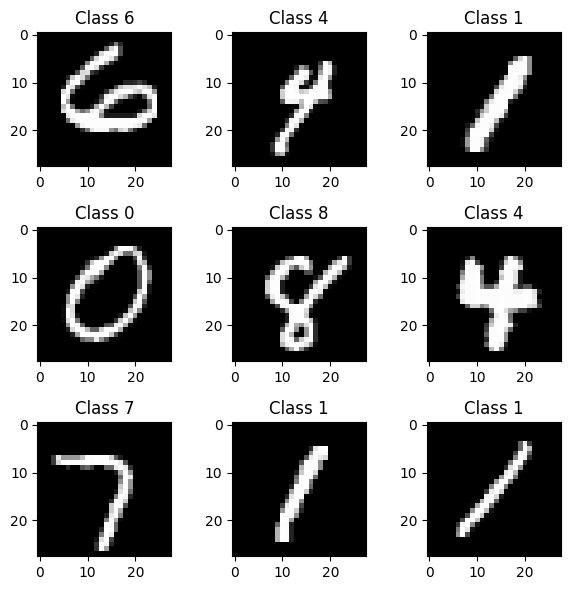

In [3]:
plt.rcParams['figure.figsize'] = (6,6)

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [4]:
# just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!
print(f'True label: {y_train[num]}')
print('Input: ')
matprint(X_train[num])

True label: 1
Input: 
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0  101  242   60  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0    0  101  253  196  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0   67  246  253  109  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0    0    0    0    0    0    0    0  134  252  241   47  0  0  0  0  0  0  
0  0  0  0  0  0    0    0    0    0    0 

For convenience purpose, instead of a `28 x 28` matrix, the network input will accept a `784 x 1` vector. Each image needs to be then reshaped (or flattened).

We'll also normalize the input values to be in the range `[0-1]` rather than `[0-255]`. Normalizing inputs is generally recommended, so that any additional dimensions (for other network architectures) are of the same scale.

<img src='https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/flatten.png?raw=1' >

In [5]:
X_train = X_train.reshape(-1, 784) # reshape 28 x 28 matrices into 784 x 1 vectors.
X_test = X_test.reshape(-1, 784) # -1 means we keep the other dimension of the dataset (i.e. number of images)

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (6000, 784)
Testing matrix shape (10000, 784)


We then encode the labels (digits) into "one-hot format", i.e.

`0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]`

`1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]`

`2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]`

With this one-hot encoding, we can intepret the labels as the probabilities of each digits (0-9)

For example, if the output of the DL model is:

`[0, 0.94, 0, 0, 0, 0, 0.06, 0, 0]`

then it is most probable that the image is that of the digit `1`.

In [6]:
nb_classes = 10 # number of unique digits

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

###2. Building a Neural network: 3-layer fully connected (FC) network

<img src="https://github.com/AviatorMoser/keras-mnist-tutorial/blob/master/figure.png?raw=1" />

First, we define the overall architecture type.

Here, a "Sequential" architecture is used. It is a linear stack of layers, with no loop or short-cut connections

In [7]:
model = Sequential()

The first layer (input layer) is a set of 512 nodes (artificial neurons).

Each node will receive elements from each input vector and apply some weight and bias to it.

Mathematically, this is equivalent to a matrix multiplication:
`y = Ax + B`, where `x` is the `1 x 784` input vector, `y` is the `1 x 512` output vector, `A` is a `784 x 512` matrix, `B` is a `1 x 512` bias vector

In [8]:
model.add(Dense(512, input_shape=(784,))) #(784,) is not a typo -- that represents a 784 length vector!

An "activation" is a non-linear function applied to the output of the layer above.

It checks the new value of the node, and decides whether that artifical neuron has fired.

The Rectified Linear Unit (ReLU) converts all negative inputs to nodes in the next layer to be zero.

Those inputs are then not considered to be fired.

Positive values of a node are unchanged.

$$f(x) = max (0,x)$$
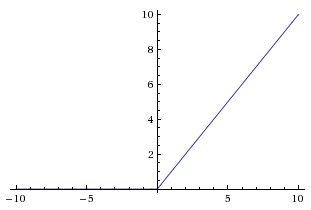

In [9]:
model.add(Activation('relu'))

Now we add the second (hidden) layer, also with 512 nodes (and thus `1 x 512` output)

In [10]:
model.add(Dense(512))
model.add(Activation('relu'))

Finally is the output layer with 10 nodes (as we would like to obtain `1 x 10` output vector in "one-hot" format).

This time, we use "softmax" as the activation. "Softmax" scale the output vector, so that all values are ***non-negative***, and **sum up to 1**.

In this way, the output vector represents the probability of being each of the 0-9 digits.

In [11]:
model.add(Dense(10))
model.add(Activation('softmax'))

We print the summary of the model:

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
 activation_2 (Activation)   (None, 10)                0         
                                                                 
Total params: 669706 (2.55 MB)
Trainable params: 669706 

During training, the network will produce its prediction based on the data and the current parameters in the so-called **forward pass**.

The prediction would be compared with the true label. The difference is represented mathematically by a **loss function**.

In the backward pass, the network parameter will be adjusted to minimize the loss function using the **gradient descent** algorithm.

This is very time consuming and requires a lot of computation power.

At the end of the training, the network parameter will hopefully produce a very small loss function value from the training set.

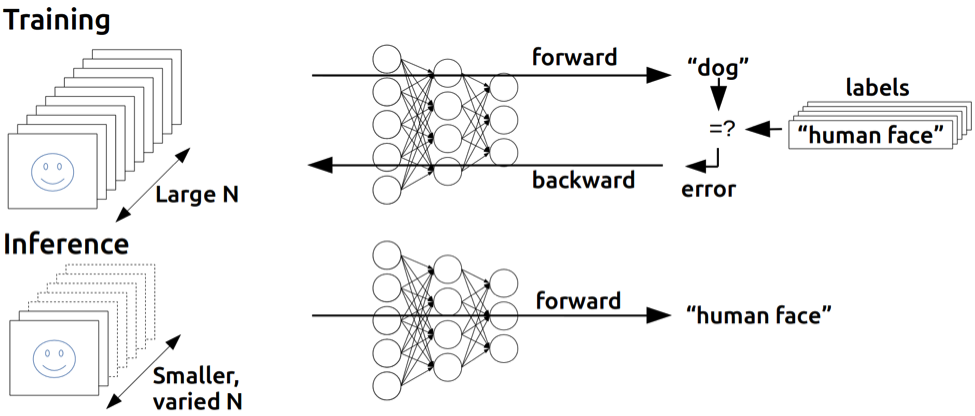

After trained, the network is used only for prediction during the so-called **inference** phase.

Only the forward pass is present. The require calculations amount to basically a small number of matrix multiplication, which is very fast.

## Compiling the model

With Keras/TensorFlow, the model is then "compiled" to run efficiently on the CPU or GPU, without the overhead of the Python interpreter.

When compiling a model, Keras asks you to specify your **loss function**, your **optimizer**, and the **metric**.

The loss function we'll use here is called *categorical cross-entropy*, and is a loss function well-suited to comparing two probability distributions.

The optimizer helps determine how quickly the model learns through **gradient descent**. The rate at which descends a gradient is called the **learning rate**.

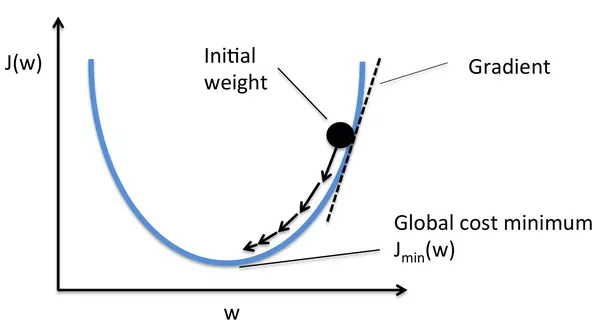

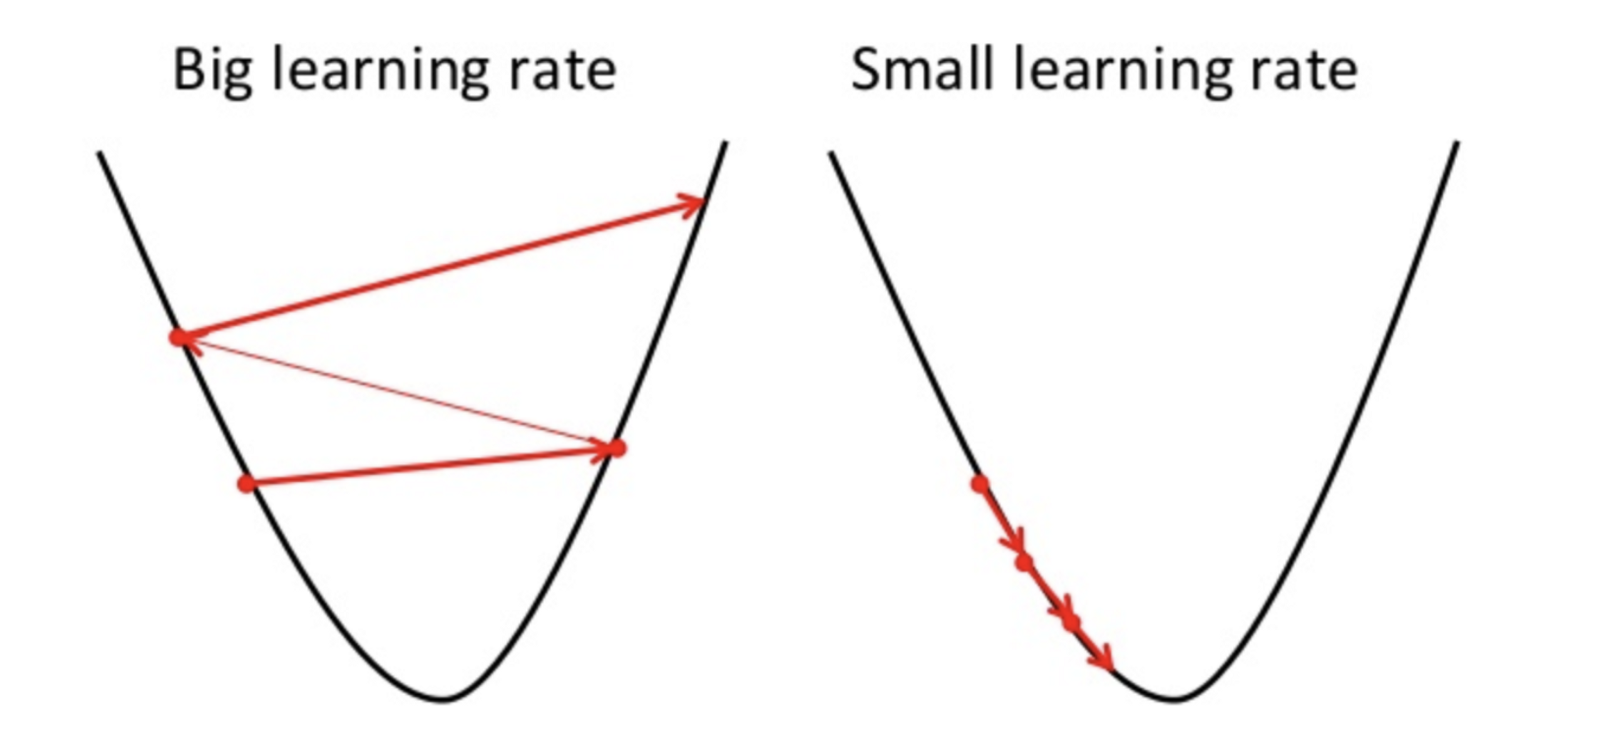

So are smaller learning rates better? Not quite! It's important for an optimizer not to get stuck in local minima while neglecting the global minimum of the loss function. Sometimes that means trying a larger learning rate to jump out of a local minimum.

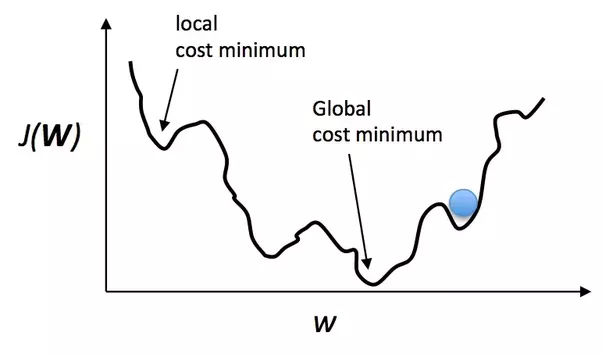

In this case, we will use the *Adam* (Adaptive moment estimation) optimizer to estimate both the initial and the subsequent learning rates.

The metrics helps the human to keep track of the training process. In this case, the *accuracy* metric was used, specifying how many percent of the model predictions was correct.

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

We have finished building the model. But it is not yet trained.

Let's check the prediction accuracy of the model:

In [14]:
score = model.evaluate(X_test, Y_test)
print('Prediction accuracy:', score[1])

313/313 [==============================] - 2s 5ms/step - loss: 2.3404 - accuracy: 0.0911
Prediction accuracy: 0.09109999984502792


## Train the model!
This is the fun part!

The **batch size** determines over how much data per step is used for training.
* Larger batch sizes speeds up the training
* Too large of a batch size smoothes the local minima of the loss function, causing the optimizer to settle in one because it thinks it found the global minimum
* Too small of a batch size creates a very noisy loss function, and the optimizer may never find the global minimum


The number of **epochs** determine how many times the network will "see" the *whole dataset*.
* Too few epochs and the network will not have learned the data well enough --> Underfitting
* Too many epochs and the network learned the training data "too well", and failed to generalize, and will not work well on data unseen before



In [15]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=8,
          verbose=1)

Epoch 1/8
47/47 [==============================] - 2s 17ms/step - loss: 0.6372 - accuracy: 0.8218
Epoch 2/8
47/47 [==============================] - 1s 24ms/step - loss: 0.2248 - accuracy: 0.9345
Epoch 3/8
47/47 [==============================] - 1s 31ms/step - loss: 0.1359 - accuracy: 0.9620
Epoch 4/8
47/47 [==============================] - 1s 29ms/step - loss: 0.0841 - accuracy: 0.9782
Epoch 5/8
47/47 [==============================] - 1s 29ms/step - loss: 0.0517 - accuracy: 0.9878
Epoch 6/8
47/47 [==============================] - 1s 28ms/step - loss: 0.0351 - accuracy: 0.9918
Epoch 7/8
47/47 [==============================] - 1s 29ms/step - loss: 0.0239 - accuracy: 0.9950
Epoch 8/8
47/47 [==============================] - 2s 35ms/step - loss: 0.0131 - accuracy: 0.9978


The two numbers, in order, represent the value of the loss function of the network on the training set, and the overall accuracy of the network on the training data. But how does it do on data it did not train on?

## Evaluate Model's Accuracy on Test Data

In [16]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 5s 15ms/step - loss: 0.1891 - accuracy: 0.9487
Test score: 0.18911544978618622
Test accuracy: 0.9487000107765198


### Inspecting the output

It's always a good idea to inspect the output and make sure everything looks sane. Here we'll look at some examples it gets right, and some examples it gets wrong.

In [17]:
# The predict_classes function outputs the highest probability class
# according to the trained classifier for each input example.
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

print(predictions[0])
print(predicted_classes[0])

# Check which items we got right / wrong
correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

313/313 [==============================] - 4s 11ms/step
[4.1774800e-10 1.1997738e-09 2.8753260e-07 2.2973725e-06 4.9638952e-12
 1.2278466e-08 2.6335455e-12 9.9999720e-01 5.3224003e-10 2.6174175e-07]
7


correct predictions
wrong predictions


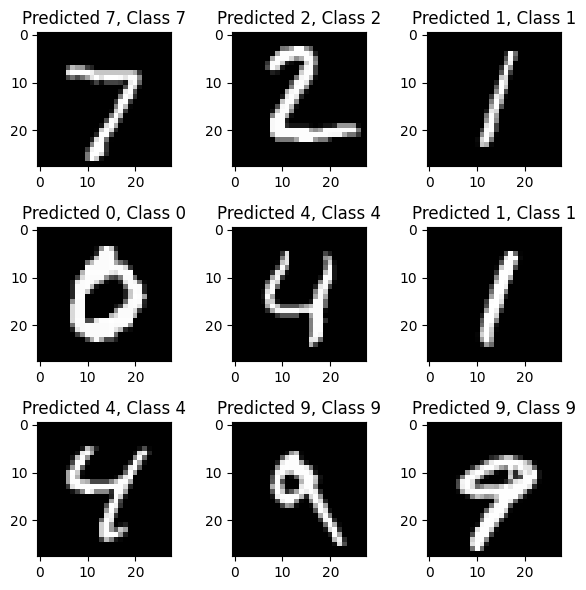

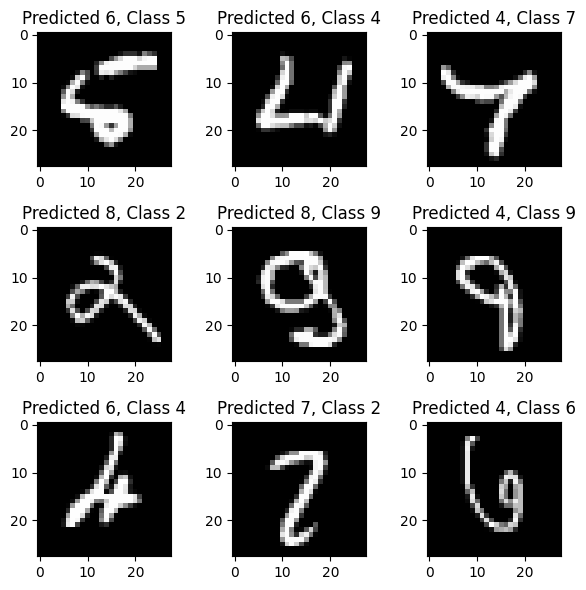

In [47]:
plt.figure()
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

plt.tight_layout()

plt.figure()
for i, incorrect in enumerate(incorrect_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

plt.tight_layout()

# Try it your self!

In [48]:
# Reload data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:6000].reshape(-1, 784)
y_train = y_train[:6000]
X_test = X_test.reshape(-1, 784)

X_train = X_train/255.0
X_test = X_test/255.0

nb_classes = 10

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

In [49]:
# Build and compile new model

model = Sequential()

# add layers here...

model.summary()

# we can try SGD optimizer
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               401920    
                                                                 
 activation_23 (Activation)  (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 activation_24 (Activation)  (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 10)                5130      
                                                                 
 activation_25 (Activation)  (None, 10)                0         
                                                                 
Total params: 669706 (2.55 MB)
Trainable params: 66970

In [50]:
# try some different batch size and number of epochs
model.fit(X_train, Y_train,
          batch_size=64, epochs=10,
          verbose=1)

Epoch 1/10
94/94 [==============================] - 2s 16ms/step - loss: 2.0006 - accuracy: 0.4703
Epoch 2/10
94/94 [==============================] - 1s 14ms/step - loss: 1.3489 - accuracy: 0.7565
Epoch 3/10
94/94 [==============================] - 1s 10ms/step - loss: 0.9001 - accuracy: 0.8170
Epoch 4/10
94/94 [==============================] - 1s 10ms/step - loss: 0.6769 - accuracy: 0.8510
Epoch 5/10
94/94 [==============================] - 1s 11ms/step - loss: 0.5594 - accuracy: 0.8697
Epoch 6/10
94/94 [==============================] - 1s 11ms/step - loss: 0.4889 - accuracy: 0.8830
Epoch 7/10
94/94 [==============================] - 1s 10ms/step - loss: 0.4408 - accuracy: 0.8915
Epoch 8/10
94/94 [==============================] - 1s 11ms/step - loss: 0.4072 - accuracy: 0.8990
Epoch 9/10
94/94 [==============================] - 1s 11ms/step - loss: 0.3810 - accuracy: 0.9030
Epoch 10/10
94/94 [==============================] - 1s 10ms/step - loss: 0.3593 - accuracy: 0.9073


In [51]:
# Testing time!
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.3877 - accuracy: 0.8938
Test score: 0.3876652419567108
Test accuracy: 0.8938000202178955


#III. Basic DL performance improvement



##1. More data!

Instead of using only the first 6000 images, we will now use all 60000 images to train the model

In [19]:
# Reload full dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train/255.0
X_test = X_test/255.0

nb_classes = 10

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

We will build a new model with the same recipe as before

In [20]:
# Build and compile new model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 512)               401920    
                                                                 
 activation_3 (Activation)   (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 activation_4 (Activation)   (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                5130      
                                                                 
 activation_5 (Activation)   (None, 10)                0         
                                                                 
Total params: 669706 (2.55 MB)
Trainable params: 66970

The model will now takes longer to train.

Nevertheless, it should be kept in mind that, normally the training time is insignificant compared to the time it takes to gather, prepare and label a larger data set.

In [21]:
# Train the model
model.fit(X_train, Y_train,
          batch_size=128, epochs=8,
          verbose=1)

Epoch 1/8
469/469 [==============================] - 13s 25ms/step - loss: 0.2201 - accuracy: 0.9350
Epoch 2/8
469/469 [==============================] - 8s 18ms/step - loss: 0.0793 - accuracy: 0.9754
Epoch 3/8
469/469 [==============================] - 16s 35ms/step - loss: 0.0516 - accuracy: 0.9836
Epoch 4/8
469/469 [==============================] - 12s 26ms/step - loss: 0.0351 - accuracy: 0.9891
Epoch 5/8
469/469 [==============================] - 10s 21ms/step - loss: 0.0265 - accuracy: 0.9916
Epoch 6/8
469/469 [==============================] - 12s 25ms/step - loss: 0.0220 - accuracy: 0.9927
Epoch 7/8
469/469 [==============================] - 9s 18ms/step - loss: 0.0172 - accuracy: 0.9944
Epoch 8/8
469/469 [==============================] - 12s 25ms/step - loss: 0.0175 - accuracy: 0.9943


Let's investigate the new test results

In [22]:
# Evaluate on test set
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 8ms/step - loss: 0.0947 - accuracy: 0.9770
Test score: 0.09466654807329178
Test accuracy: 0.9769999980926514


##2. Regularization

Regularizations are techniques to help the network/model learns better (faster and with better test results).

When the network does not learn well, it is prone to over/underfitting.


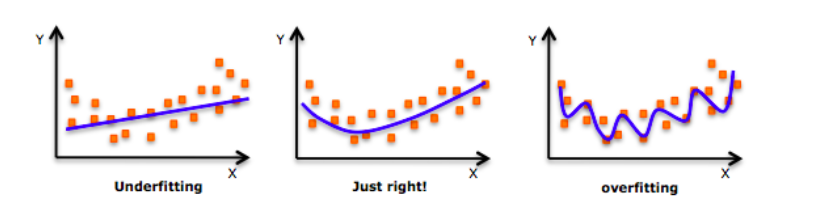

Here, we try a technique called *Dropout*, which randomly *dropping out* a certain percent of the output of a fully-connected layer.

It helps preventing overfitting.

Thus this is equivalent to disabling some neuron of subsequent layers.

In [23]:
# We will try drop out on a smaller training set of 6000 samples
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train[:6000].reshape(-1, 784)
y_train = y_train[:6000]
X_test = X_test.reshape(-1, 784)

X_train = X_train/255.0
X_test = X_test/255.0

nb_classes = 10

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

In [24]:
# Build and compile new model
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2)) # dropout rate of 20%
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 512)               401920    
                                                                 
 activation_6 (Activation)   (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 activation_7 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 10)               

In [25]:
# Train the model
model.fit(X_train, Y_train,
          batch_size=128, epochs=8,
          verbose=1)

Epoch 1/8
47/47 [==============================] - 3s 31ms/step - loss: 0.7008 - accuracy: 0.7888
Epoch 2/8
47/47 [==============================] - 1s 31ms/step - loss: 0.2616 - accuracy: 0.9253
Epoch 3/8
47/47 [==============================] - 1s 25ms/step - loss: 0.1690 - accuracy: 0.9528
Epoch 4/8
47/47 [==============================] - 1s 19ms/step - loss: 0.1223 - accuracy: 0.9657
Epoch 5/8
47/47 [==============================] - 1s 20ms/step - loss: 0.0861 - accuracy: 0.9768
Epoch 6/8
47/47 [==============================] - 1s 20ms/step - loss: 0.0644 - accuracy: 0.9835
Epoch 7/8
47/47 [==============================] - 1s 20ms/step - loss: 0.0497 - accuracy: 0.9865
Epoch 8/8
47/47 [==============================] - 1s 20ms/step - loss: 0.0352 - accuracy: 0.9920


In [26]:
# Evaluate on test set
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 5ms/step - loss: 0.1858 - accuracy: 0.9472
Test score: 0.18584127724170685
Test accuracy: 0.9472000002861023


###3. Deeper network

When there is complex relationship between data and output, the model needs to be complex enough to capture it.

A too simple model for complex, large dataset may lead to underfitting.

We can increase complexity by increasing the depth (number of layers) and width (number of neurons/layer)

In [27]:
# Reload full dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train/255.0
X_test = X_test/255.0

nb_classes = 10

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

We will add one more layer to the model.

In [28]:
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               401920    
                                                                 
 activation_9 (Activation)   (None, 512)               0         
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 activation_10 (Activation)  (None, 512)               0         
                                                                 
 dropout_3 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 512)              

Larger/deeper model may needs longer to train

In [29]:
model.fit(X_train, Y_train,
          batch_size=128, epochs=10,
          verbose=1)

Epoch 1/10
469/469 [==============================] - 27s 54ms/step - loss: 0.2749 - accuracy: 0.9155
Epoch 2/10
469/469 [==============================] - 19s 41ms/step - loss: 0.1183 - accuracy: 0.9638
Epoch 3/10
469/469 [==============================] - 23s 50ms/step - loss: 0.0882 - accuracy: 0.9735
Epoch 4/10
469/469 [==============================] - 25s 53ms/step - loss: 0.0761 - accuracy: 0.9774
Epoch 5/10
469/469 [==============================] - 26s 55ms/step - loss: 0.0620 - accuracy: 0.9811
Epoch 6/10
469/469 [==============================] - 20s 44ms/step - loss: 0.0569 - accuracy: 0.9822
Epoch 7/10
469/469 [==============================] - 20s 43ms/step - loss: 0.0477 - accuracy: 0.9852
Epoch 8/10
469/469 [==============================] - 20s 43ms/step - loss: 0.0437 - accuracy: 0.9868
Epoch 9/10
469/469 [==============================] - 29s 63ms/step - loss: 0.0401 - accuracy: 0.9879
Epoch 10/10
469/469 [==============================] - 31s 65ms/step - loss: 0.039

In [30]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 8ms/step - loss: 0.0746 - accuracy: 0.9814
Test score: 0.07462266087532043
Test accuracy: 0.9814000129699707


### 4. Even more data!

The full dataset is limited at 60000 training images. We would like to improve the performance of the model by training it with more data.

How can we do it?

In [31]:
#reload full data set
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1,  28, 28, 1)

X_train = X_train/255.0
X_test = X_test/255.0

nb_classes = 10

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

For images data, it is possible to create new training data by distorting (rotate, shift, sheer, zoom) the original images, while preserving the same label.

Thus, a lot of new training data could be generated very easily.

The network could also adapt better to a new data, thus performing better on the test set.

In [32]:
# Specify a generator, which creates distorted images
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Flatten

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()
train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [33]:
# Rebuild a new model
model = Sequential()
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))
model.build(input_shape=(128,784))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (128, 784)                0         
                                                                 
 dense_14 (Dense)            (128, 512)                401920    
                                                                 
 activation_14 (Activation)  (128, 512)                0         
                                                                 
 dropout_6 (Dropout)         (128, 512)                0         
                                                                 
 dense_15 (Dense)            (128, 512)                262656    
                                                                 
 activation_15 (Activation)  (128, 512)                0         
                                                                 
 dropout_7 (Dropout)         (128, 512)               

In [34]:
# Training
model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1,
                    validation_data=test_generator, validation_steps=10000//128)

<ipython-input-34-cc175e0393ff>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1,


Epoch 1/5
468/468 [==============================] - 51s 104ms/step - loss: 0.4266 - accuracy: 0.8678 - val_loss: 0.1088 - val_accuracy: 0.9645
Epoch 2/5
468/468 [==============================] - 36s 77ms/step - loss: 0.1880 - accuracy: 0.9418 - val_loss: 0.0809 - val_accuracy: 0.9736
Epoch 3/5
468/468 [==============================] - 39s 84ms/step - loss: 0.1549 - accuracy: 0.9532 - val_loss: 0.0674 - val_accuracy: 0.9764
Epoch 4/5
468/468 [==============================] - 39s 82ms/step - loss: 0.1350 - accuracy: 0.9571 - val_loss: 0.0614 - val_accuracy: 0.9793
Epoch 5/5
468/468 [==============================] - 37s 78ms/step - loss: 0.1206 - accuracy: 0.9619 - val_loss: 0.0569 - val_accuracy: 0.9822


In [35]:
# Evaluate on the test set
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 5ms/step - loss: 0.0568 - accuracy: 0.9822
Test score: 0.05682314932346344
Test accuracy: 0.982200026512146


### Introducing the convolutional neural network (CNN)

Currently, the best results for the MNIST data are around **99.5%**

How do they do it?

A new network architecture was used, called Convolutional Neural Network (CNN), which makes use of different types of layers.

Of course, all the techniques introduced above were also applied.

Some luck was also needed to achieve the best possible results!

Before, we built a network that accepts the normalized pixel values of each value and operates soley on those values. What if we could instead feed different features (e.g. **curvature, edges**) of each image into a network, and have the network learn which features are important for classifying an image?

This possible through convolution! Convolution applies **kernels** (filters) that traverse through each image and generate **feature maps**.

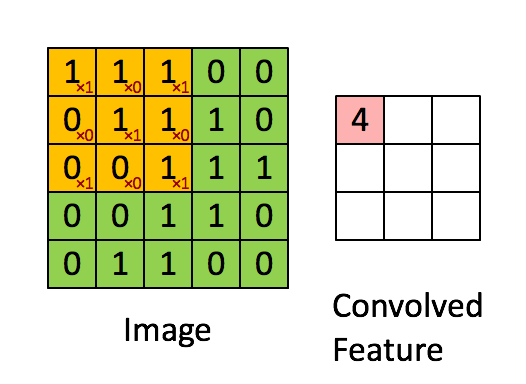

In the above example, the image is a 5 x 5 matrix and the kernel going over it is a 3 x 3 matrix. A dot product operation takes place between the image and the kernel and the convolved feature is generated. Each kernel in a CNN learns a different characteristic of an image.

Kernels are often used in photoediting software to apply blurring, edge detection, sharpening, etc.

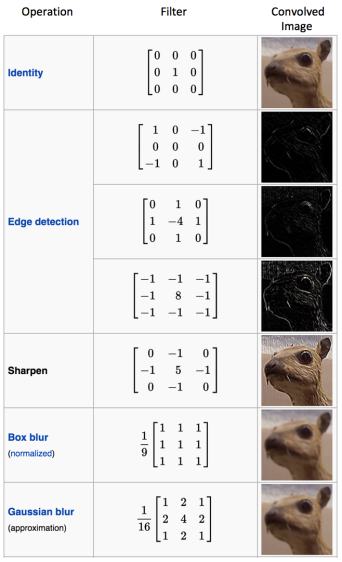

Kernels in deep learning networks are used in similar ways, i.e. highlighting some feature. Combined with a system called **max pooling**, the non-highlighted elements are discarded from each feature map, leaving only the features of interest, reducing the number of learned parameters, and decreasing the computational cost (e.g. system memory).

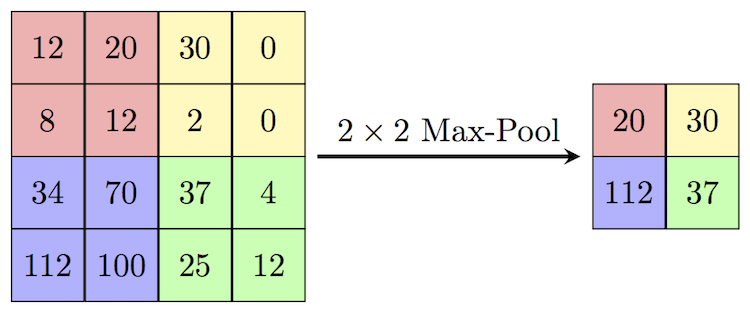

We can also take convolutions of convolutions -- we can stack as many convolutions as we want, as long as there are enough pixels to fit a kernel.

*Warning: What you may find down there in those deep convolutions may not appear recognizable to you.*

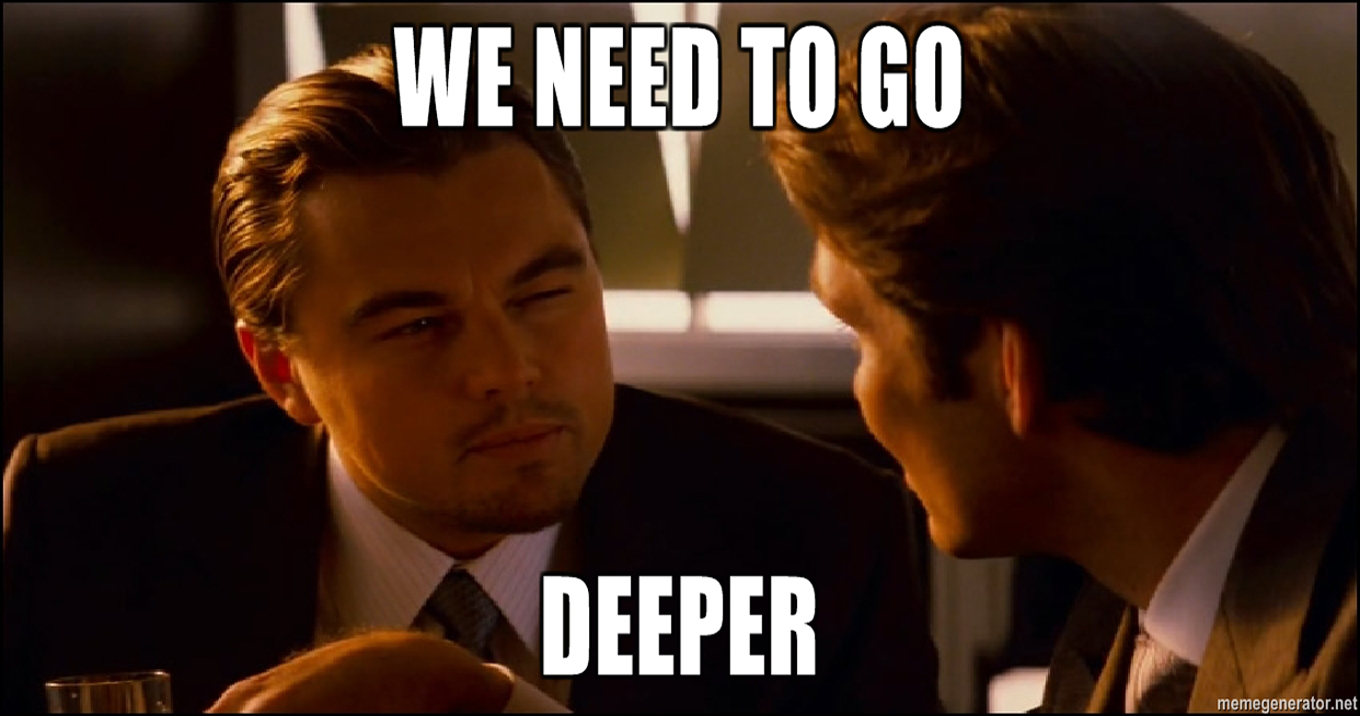

## Building a "Deep" Convolutional Neural Network

In [36]:
# import some additional tools

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers import BatchNormalization

In [37]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [38]:
# Again, do some formatting
# Except we do not flatten each image into a 784-length vector because we want to perform convolutions first

X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


In [39]:
# one-hot format classes

nb_classes = 10 # number of unique digits

Y_train = utils.to_categorical(y_train, nb_classes)
Y_test = utils.to_categorical(y_test, nb_classes)

In [40]:
model = Sequential()                                 # Linear stacking of layers

# Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1))) # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer01 = Activation('relu')                     # activation
model.add(convLayer01)

# Convolution Layer 2
model.add(Conv2D(32, (3, 3)))                        # 32 different 3x3 kernels -- so 32 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer02 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer02)

# Convolution Layer 3
model.add(Conv2D(64,(3, 3)))                         # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
convLayer03 = Activation('relu')                     # activation
model.add(convLayer03)

# Convolution Layer 4
model.add(Conv2D(64, (3, 3)))                        # 64 different 3x3 kernels -- so 64 feature maps
model.add(BatchNormalization(axis=-1))               # normalize each feature map before activation
model.add(Activation('relu'))                        # activation
convLayer04 = MaxPooling2D(pool_size=(2,2))          # Pool the max values over a 2x2 kernel
model.add(convLayer04)
model.add(Flatten())                                 # Flatten final 4x4x64 output matrix into a 1024-length vector

# Fully Connected Layer 5
model.add(Dense(512))                                # 512 FCN nodes
model.add(BatchNormalization())                      # normalization
model.add(Activation('relu'))                        # activation

# Fully Connected Layer 6
model.add(Dropout(0.2))                              # 20% dropout of randomly selected nodes
model.add(Dense(10))                                 # final 10 FCN nodes
model.add(Activation('softmax'))                     # softmax activation

In [41]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 32)        128       
 Normalization)                                                  
                                                                 
 activation_17 (Activation)  (None, 26, 26, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 32)        128       
 chNormalization)                                                
                                                                 
 activation_18 (Activation)  (None, 24, 24, 32)       

In [42]:
# we'll use the same optimizer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [43]:
# data augmentation prevents overfitting by slightly changing the data randomly
# Keras has a great built-in feature to do automatic augmentation

gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [44]:
# We can then feed our augmented data in batches
# Besides loss function considerations as before, this method actually results in significant memory savings
# because we are actually LOADING the data into the network in batches before processing each batch

# Before the data was all loaded into memory, but then processed in batches.

train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

In [45]:
# We can now train our model which is fed data by our batch loader
# Steps per epoch should always be total size of the set divided by the batch size

# SIGNIFICANT MEMORY SAVINGS (important for larger, deeper networks)

model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1,
                    validation_data=test_generator, validation_steps=10000//128)

Epoch 1/5


<ipython-input-45-758777735d04>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=5, verbose=1,


468/468 [==============================] - 227s 477ms/step - loss: 0.1313 - accuracy: 0.9598 - val_loss: 0.0650 - val_accuracy: 0.9833
Epoch 2/5
468/468 [==============================] - 218s 465ms/step - loss: 0.0500 - accuracy: 0.9847 - val_loss: 0.0275 - val_accuracy: 0.9914
Epoch 3/5
468/468 [==============================] - 219s 467ms/step - loss: 0.0407 - accuracy: 0.9874 - val_loss: 0.0199 - val_accuracy: 0.9936
Epoch 4/5
468/468 [==============================] - 241s 515ms/step - loss: 0.0335 - accuracy: 0.9899 - val_loss: 0.0487 - val_accuracy: 0.9846
Epoch 5/5
468/468 [==============================] - 305s 651ms/step - loss: 0.0312 - accuracy: 0.9906 - val_loss: 0.0185 - val_accuracy: 0.9941


In [46]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 15s 49ms/step - loss: 0.0184 - accuracy: 0.9941
Test score: 0.018444497138261795
Test accuracy: 0.9940999746322632
